# DataKind Red Cross Project Phase 2
## Home Fire Risk Data Model
10/28/2019
Tasks:
1. <b>Home Fire County Assessment</b>: Score and rank order counties based on highest fire rates per-capita using NFIRS Data (aggregate) and SVI population estimates
2. <b>Home Fire Census Tract Assessment</b>: Score and rank order census tracts based on highest fire rates per-capita using NFIRS Data (aggregate) and SVI population estimates
3. <b>Home Fire Severity Assessment (county)</b>: Score and rank order counties based on rates of severe fires per-capita using NFIRS Data (aggregate) and SVI population estimates.
4. <b>Home Fire Severity Assessment (census tract)</b>Score and rank order census tracts based on rates of severe fires per-capita using NFIRS Data (aggregate) and SVI population estimates
5. <b>Home Fire Predictablility Assessment</b>: Using Census Tract Fire Severity Assesment bin Data at 3-month 6-month or 1-year intervals and train simple linear/logistic regression model

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.set_option('display.max_columns',500)
sns.set()

# 1. Data Import and Cleaning

## 1.1 NFIRS Data

First, make sure that I import the dataset correctly and get the column dtypes correct so that data isn't lost (for id numbers with leading zeros for example)

In [6]:
nfirs_path = '../data/01_raw/NFIRS_2009_2016_Combined_Census_Tract.csv'

cols_to_use = ['inc_date','oth_inj','oth_death','prop_loss',
               'cont_loss','tot_loss','GEOID']
col_dtypes = {'GEOID':str}

nfirs = pd.read_csv(nfirs_path,
                    dtype = col_dtypes,
                    usecols = cols_to_use,
                    encoding='latin-1')

nfirs['inc_date'] = pd.to_datetime(nfirs['inc_date'], infer_datetime_format=True)

In [7]:
# Add the severe fire column to the dataset
sev_fire_mask = (nfirs['oth_death'] > 0) | (nfirs['oth_inj'] > 0) | (nfirs['tot_loss'] >= 10000)
nfirs['severe_fire'] = 'not_sev_fire'
nfirs.loc[sev_fire_mask,'severe_fire'] = 'sev_fire'

In [8]:
nfirs.sample(5)

,inc_date,oth_inj,oth_death,prop_loss,cont_loss,tot_loss,GEOID,severe_fire
580814,2011-03-10,0.0,0.0,0.0,0.0,0.0,25021420302.0,not_sev_fire
1819373,2016-05-07,NaN,NaN,0.0,0.0,0.0,10003012000.0,not_sev_fire
66753,2009-03-08,0.0,0.0,0.0,0.0,0.0,20011955600.0,not_sev_fire
880045,2012-11-17,NaN,NaN,1000.0,0.0,1000.0,32003002950.0,not_sev_fire
1004481,2013-11-27,NaN,NaN,5000.0,0.0,5000.0,12031015400.0,not_sev_fire


## 1.2 Fix GEOIDs (add leading zeros to correct columns)
It seems that a lot of the GEOIDs are missing the leading 0. For now I'm just going to add a leading 0 if the GEOID length is 10.

In [9]:
nfirs['GEOID'].str.len().value_counts()

13.0    1442479
12.0     196432
Name: GEOID, dtype: int64

In [10]:
nfirs['GEOID'] = (nfirs['GEOID'].str[:-2]
                  .str.zfill(11))

In [11]:
nfirs.head()

,inc_date,oth_inj,oth_death,prop_loss,cont_loss,tot_loss,GEOID,severe_fire
0,2009-01-03,0.0,0.0,20000.0,5000.0,25000.0,02110000500,sev_fire
1,2009-01-06,0.0,0.0,0.0,0.0,0.0,02110000600,not_sev_fire
2,2009-01-06,0.0,0.0,20000.0,5000.0,25000.0,02110000100,sev_fire
3,2009-01-13,0.0,0.0,200.0,20.0,220.0,02110000400,not_sev_fire
4,2009-01-21,0.0,0.0,35000.0,5000.0,40000.0,02110000400,sev_fire


In [12]:
# Add a year column to be used to groupby in addition to GEOID
nfirs['year'] = nfirs['inc_date'].dt.year

## 1.3 SVI Data

In [13]:
svi2016_path = '../data/01_raw/SVI2016_US.csv'
svi2016_top = pd.read_csv(svi2016_path,nrows=1000)

svi_col_dtypes = {'ST':str,'STCNTY':str,'FIPS':str}

svi2016 = pd.read_csv(svi2016_path,
                     index_col=0,
                     dtype = svi_col_dtypes)

In [14]:
svi2016.head(3)

,ST,STATE,ST_ABBR,STCNTY,COUNTY,FIPS,LOCATION,AREA_SQMI,E_TOTPOP,M_TOTPOP,E_HU,M_HU,E_HH,M_HH,E_POV,M_POV,E_UNEMP,M_UNEMP,E_PCI,M_PCI,E_NOHSDP,M_NOHSDP,E_AGE65,M_AGE65,E_AGE17,M_AGE17,E_DISABL,M_DISABL,E_SNGPNT,M_SNGPNT,E_MINRTY,M_MINRTY,E_LIMENG,M_LIMENG,E_MUNIT,M_MUNIT,E_MOBILE,M_MOBILE,E_CROWD,M_CROWD,E_NOVEH,M_NOVEH,E_GROUPQ,M_GROUPQ,EP_POV,MP_POV,EP_UNEMP,MP_UNEMP,EP_PCI,MP_PCI,EP_NOHSDP,MP_NOHSDP,EP_AGE65,MP_AGE65,EP_AGE17,MP_AGE17,EP_DISABL,MP_DISABL,EP_SNGPNT,MP_SNGPNT,EP_MINRTY,MP_MINRTY,EP_LIMENG,MP_LIMENG,EP_MUNIT,MP_MUNIT,EP_MOBILE,MP_MOBILE,EP_CROWD,MP_CROWD,EP_NOVEH,MP_NOVEH,EP_GROUPQ,MP_GROUPQ,EPL_POV,EPL_UNEMP,EPL_PCI,EPL_NOHSDP,SPL_THEME1,RPL_THEME1,EPL_AGE65,EPL_AGE17,EPL_DISABL,EPL_SNGPNT,SPL_THEME2,RPL_THEME2,EPL_MINRTY,EPL_LIMENG,SPL_THEME3,RPL_THEME3,EPL_MUNIT,EPL_MOBILE,EPL_CROWD,EPL_NOVEH,EPL_GROUPQ,SPL_THEME4,RPL_THEME4,SPL_THEMES,RPL_THEMES,F_POV,F_UNEMP,F_PCI,F_NOHSDP,F_THEME1,F_AGE65,F_AGE17,F_DISABL,F_SNGPNT,F_THEME2,F_MINRTY,F_LIMENG,F_THEME3,F_MUNIT,F_MOBILE,F_CROWD,F_NOVEH,F_GROUPQ,F_THEME4,F_TOTAL,E_UNINSUR,M_UNINSUR,EP_UNINSUR,MP_UNINSUR,E_DAYPOP
FID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,01,ALABAMA,AL,01015,Calhoun,01015981902,"Census Tract 9819.02, Calhoun County, Alabama",34.644448,0.0,11.0,0.0,11.0,0.0,11.0,0.0,11.0,0.0,11.0,-999.0,-999.0,0.0,11.0,0.0,11.0,0.0,11.0,0.0,11.0,0.0,15.6,0.0,15.6,0.0,44.0,0.0,15.6,0.0,11.0,0.0,15.6,0.0,11.0,0.0,11.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,0.0,-999.0,0.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,11.0,-999.0,-999.0,335.0
1,01,ALABAMA,AL,01015,Calhoun,01015981903,"Census Tract 9819.03, Calhoun County, Alabama",13.929908,0.0,11.0,0.0,11.0,0.0,11.0,0.0,11.0,0.0,11.0,-999.0,-999.0,0.0,11.0,0.0,11.0,0.0,11.0,0.0,11.0,0.0,15.6,0.0,15.6,0.0,44.0,0.0,15.6,0.0,11.0,0.0,15.6,0.0,11.0,0.0,11.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,0.0,-999.0,0.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,11.0,-999.0,-999.0,0.0
2,01,ALABAMA,AL,01097,Mobile,01097990000,"Census Tract 9900, Mobile County, Alabama",0.000000,0.0,11.0,0.0,11.0,0.0,11.0,0.0,11.0,0.0,11.0,-999.0,-999.0,0.0,11.0,0.0,11.0,0.0,11.0,0.0,11.0,0.0,15.6,0.0,15.6,0.0,44.0,0.0,15.6,0.0,11.0,0.0,15.6,0.0,11.0,0.0,11.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,0.0,-999.0,0.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,11.0,-999.0,-999.0,0.0


# 2. Tasks 1 & 3

- Task 1: <b>Home Fire County Assessment</b>: Score and rank order counties based on highest fire rates per-capita using NFIRS Data (aggregate) and SVI population estimates
- Task 3: <b>Home Fire Severity Assessment (county)</b>: Score and rank order counties based on rates of severe fires per-capita using NFIRS Data (aggregate) and SVI population estimates.

In [15]:
# add the state+county unique identifier column to nfirs
nfirs['STCNTY'] = nfirs['GEOID'].str[:5]

# Do frequency counts based on the year & the number of severe vs non-severe fires
nfirs_counties = pd.crosstab(nfirs['STCNTY'],[nfirs['year'],nfirs['severe_fire']])

# Iterate through years and calculate the total number of fires
for year in [2009,2010,2011,2012,2013,2014,2015,2016]:
    nfirs_counties[(year,'tot_fires')] = nfirs_counties[(year,'not_sev_fire')] + nfirs_counties[(year,'sev_fire')]

# Sort the columns
nfirs_counties = nfirs_counties[sorted(nfirs_counties.columns)]

# aggregate svi data by county
svi2016_counties = svi2016.groupby('STCNTY').agg({'E_TOTPOP':'sum'})

# add nfirs data to svi data and insure it's a one-to-one merge
nfirs_svi_counties = svi2016_counties.merge(nfirs_counties,how='left',left_index=True,right_index=True, validate='one_to_one')

nfirs_svi_counties_rates = nfirs_svi_counties[['E_TOTPOP']].copy()

# Calculate the per capita fire rates
for year in [2009,2010,2011,2012,2013,2014,2015,2016]:
    nfirs_svi_counties_rates[str(year) + '_tot_fire_rate_per_cap'] = nfirs_svi_counties[(year,'tot_fires')] / nfirs_svi_counties['E_TOTPOP']
    nfirs_svi_counties_rates[str(year) + '_sev_fire_rate_per_cap'] = nfirs_svi_counties[(year,'sev_fire')] / nfirs_svi_counties['E_TOTPOP']

# Add the county and state columns to the dataset
nfirs_svi_counties_rates = nfirs_svi_counties_rates.merge(svi2016[['COUNTY','ST_ABBR','STCNTY']].drop_duplicates(subset='STCNTY'),how='left',left_index=True,right_on='STCNTY')
nfirs_svi_counties_rates = nfirs_svi_counties_rates.set_index('STCNTY')

# create list of severe columns & total columns
sev_cols = nfirs_svi_counties_rates.columns[nfirs_svi_counties_rates.columns.str.contains('sev_')]
tot_cols = nfirs_svi_counties_rates.columns[nfirs_svi_counties_rates.columns.str.contains('tot_')]

# calculate mean and standard deviation from 2009-2016
nfirs_svi_counties_rates['avg_sev_fire_rate_per_cap'] = nfirs_svi_counties_rates[sev_cols].mean(axis=1)
nfirs_svi_counties_rates['std_sev_fire_rate_per_cap'] = nfirs_svi_counties_rates[sev_cols].std(axis=1)
nfirs_svi_counties_rates['avg_tot_fire_rate_per_cap'] = nfirs_svi_counties_rates[tot_cols].mean(axis=1)
nfirs_svi_counties_rates['std_tot_fire_rate_per_cap'] = nfirs_svi_counties_rates[tot_cols].std(axis=1)

# Rearrange columns
first_cols = ['ST_ABBR','COUNTY','E_TOTPOP','avg_tot_fire_rate_per_cap','std_tot_fire_rate_per_cap',
              'avg_sev_fire_rate_per_cap','std_sev_fire_rate_per_cap']
cols = list(nfirs_svi_counties_rates.columns)
cols = first_cols + [col for col in cols if col not in first_cols]
nfirs_svi_counties_rates = nfirs_svi_counties_rates[cols]

C:\Users\thwhi\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:522: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


In [16]:
nfirs_svi_counties_rates.head()

,ST_ABBR,COUNTY,E_TOTPOP,avg_tot_fire_rate_per_cap,std_tot_fire_rate_per_cap,avg_sev_fire_rate_per_cap,std_sev_fire_rate_per_cap,2009_tot_fire_rate_per_cap,2009_sev_fire_rate_per_cap,2010_tot_fire_rate_per_cap,2010_sev_fire_rate_per_cap,2011_tot_fire_rate_per_cap,2011_sev_fire_rate_per_cap,2012_tot_fire_rate_per_cap,2012_sev_fire_rate_per_cap,2013_tot_fire_rate_per_cap,2013_sev_fire_rate_per_cap,2014_tot_fire_rate_per_cap,2014_sev_fire_rate_per_cap,2015_tot_fire_rate_per_cap,2015_sev_fire_rate_per_cap,2016_tot_fire_rate_per_cap,2016_sev_fire_rate_per_cap
STCNTY,,,,,,,,,,,,,,,,,,,,,,,
01001,AL,Autauga,55049.0,0.000459,0.000164,0.000170,0.000166,0.000708,0.000236,0.000490,0.000163,0.000527,0.000127,0.000254,0.000036,0.000436,0.000073,0.000200,0.000036,0.000563,0.000545,0.000490,0.000145
01003,AL,Baldwin,199510.0,0.000465,0.000099,0.000134,0.000150,0.000366,0.000080,0.000471,0.000075,0.000381,0.000100,0.000441,0.000065,0.000396,0.000050,0.000677,0.000125,0.000501,0.000501,0.000486,0.000075
01005,AL,Barbour,26614.0,0.000244,0.000143,0.000085,0.000089,0.000376,0.000113,0.000451,0.000000,0.000150,0.000000,0.000301,0.000188,0.000038,0.000000,0.000338,0.000225,0.000113,0.000113,0.000188,0.000038
01007,AL,Bibb,22572.0,0.000072,0.000062,0.000044,0.000033,0.000044,0.000044,0.000044,0.000044,0.000089,0.000044,0.000177,0.000044,0.000000,0.000000,0.000000,0.000000,0.000089,0.000089,0.000133,0.000089
01009,AL,Blount,57704.0,0.000390,0.000196,0.000121,0.000086,0.000364,0.000069,0.000399,0.000069,0.000468,0.000243,0.000277,0.000087,0.000208,0.000069,0.000295,0.000069,0.000277,0.000277,0.000832,0.000087


### Save fire rates by county

In [17]:
nfirs_svi_counties_rates.to_csv('../data/02_interim/Per_capita_fire_rates_by_county.csv')

# 3. Tasks 2 & 4

- Task 2: <b>Home Fire Census Tract Assessment</b>: Score and rank order census tracts based on highest fire rates per-capita using NFIRS Data (aggregate) and SVI population estimates
- Task 4: <b>Home Fire Severity Assessment (census tract)</b>Score and rank order census tracts based on rates of severe fires per-capita using NFIRS Data (aggregate) and SVI population 

In [18]:
# Do frequency counts based on the year & the number of severe vs non-severe fires
nfirs_tracts = pd.crosstab(nfirs['GEOID'],[nfirs['year'],nfirs['severe_fire']])

# Iterate through years and calculate the total number of fires
for year in nfirs['year'].unique():
    nfirs_tracts[(year,'tot_fires')] = nfirs_tracts[(year,'not_sev_fire')] + nfirs_tracts[(year,'sev_fire')]

# Sort the columns
nfirs_tracts = nfirs_tracts[sorted(nfirs_tracts.columns)]

# data already aggregated by census tract, so simply select the columns to merge
svi2016_tracts = svi2016[['FIPS','ST_ABBR','COUNTY','LOCATION','E_TOTPOP']].set_index('FIPS')

# add nfirs data to svi data and insure it's a one-to-one merge
nfirs_svi_tracts = svi2016_tracts.merge(nfirs_tracts,how='left',left_index=True,right_index=True, validate='one_to_one')

nfirs_svi_tracts_rates = nfirs_svi_tracts[['ST_ABBR','COUNTY','LOCATION','E_TOTPOP']].copy()

# Calculate the per capita fire rates
for year in [2009,2010,2011,2012,2013,2014,2015,2016]:
    nfirs_svi_tracts_rates[str(year) + '_tot_fire_rate_per_cap'] = nfirs_svi_tracts[(year,'tot_fires')] / nfirs_svi_tracts['E_TOTPOP']
    nfirs_svi_tracts_rates[str(year) + '_sev_fire_rate_per_cap'] = nfirs_svi_tracts[(year,'sev_fire')] / nfirs_svi_tracts['E_TOTPOP']

nfirs_svi_tracts_rates.index.name = 'GEOID'

# create list of severe columns & total columns
sev_cols = nfirs_svi_tracts_rates.columns[nfirs_svi_tracts_rates.columns.str.contains('sev_')]
tot_cols = nfirs_svi_tracts_rates.columns[nfirs_svi_tracts_rates.columns.str.contains('tot_')]

# calculate mean and standard deviation from 2009-2016
nfirs_svi_tracts_rates['avg_sev_fire_rate_per_cap'] = nfirs_svi_tracts_rates[sev_cols].mean(axis=1)
nfirs_svi_tracts_rates['std_sev_fire_rate_per_cap'] = nfirs_svi_tracts_rates[sev_cols].std(axis=1)
nfirs_svi_tracts_rates['avg_tot_fire_rate_per_cap'] = nfirs_svi_tracts_rates[tot_cols].mean(axis=1)
nfirs_svi_tracts_rates['std_tot_fire_rate_per_cap'] = nfirs_svi_tracts_rates[tot_cols].std(axis=1)

# Rearrange columns
first_cols = ['ST_ABBR','COUNTY','E_TOTPOP','LOCATION','avg_tot_fire_rate_per_cap','std_tot_fire_rate_per_cap',
              'avg_sev_fire_rate_per_cap','std_sev_fire_rate_per_cap']
cols = list(nfirs_svi_tracts_rates.columns)
cols = first_cols + [col for col in cols if col not in first_cols]
nfirs_svi_tracts_rates = nfirs_svi_tracts_rates[cols]

In [19]:
nfirs_svi_tracts_rates.sample(5)

,ST_ABBR,COUNTY,E_TOTPOP,LOCATION,avg_tot_fire_rate_per_cap,std_tot_fire_rate_per_cap,avg_sev_fire_rate_per_cap,std_sev_fire_rate_per_cap,2009_tot_fire_rate_per_cap,2009_sev_fire_rate_per_cap,2010_tot_fire_rate_per_cap,2010_sev_fire_rate_per_cap,2011_tot_fire_rate_per_cap,2011_sev_fire_rate_per_cap,2012_tot_fire_rate_per_cap,2012_sev_fire_rate_per_cap,2013_tot_fire_rate_per_cap,2013_sev_fire_rate_per_cap,2014_tot_fire_rate_per_cap,2014_sev_fire_rate_per_cap,2015_tot_fire_rate_per_cap,2015_sev_fire_rate_per_cap,2016_tot_fire_rate_per_cap,2016_sev_fire_rate_per_cap
GEOID,,,,,,,,,,,,,,,,,,,,,,,,
49035113105,UT,Salt Lake,4773.0,"Census Tract 1131.05, Salt Lake County, Utah",0.000131,0.000192,0.000052,0.000148,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000210,0.000000,0.000419,0.000419,0.000419,0.000000
51059480503,VA,Fairfax,3399.0,"Census Tract 4805.03, Fairfax County, Virginia",0.000294,0.000272,0.000110,0.000219,0.000000,0.000000,0.000294,0.000000,0.000588,0.000294,0.000294,0.0,0.000000,0.000000,0.000588,0.000000,0.000588,0.000588,0.000000,0.000000
06081610601,CA,San Mateo,6113.0,"Census Tract 6106.01, San Mateo County, Califo...",0.000266,0.000246,0.000102,0.000122,0.000164,0.000000,0.000164,0.000164,0.000491,0.000327,0.000000,0.0,0.000000,0.000000,0.000654,0.000164,0.000164,0.000164,0.000491,0.000000
36027190301,NY,Dutchess,3493.0,"Census Tract 1903.01, Dutchess County, New York",0.000394,0.000262,0.000036,0.000101,0.000573,0.000000,0.000000,0.000000,0.000286,0.000000,0.000286,0.0,0.000286,0.000000,0.000859,0.000000,0.000573,0.000286,0.000286,0.000000
48201543001,TX,Harris,12087.0,"Census Tract 5430.01, Harris County, Texas",0.000259,0.000190,0.000134,0.000098,0.000165,0.000083,0.000496,0.000331,0.000165,0.000083,0.000000,0.0,0.000248,0.000165,0.000248,0.000083,0.000165,0.000165,0.000579,0.000165


### Save fire rates by census_tract

In [20]:
nfirs_svi_tracts_rates.to_csv('../data/02_interim/Per_capita_fire_rates_by_census_tract.csv')

# More Exploratory Analysis

In [56]:
df = nfirs_svi_counties.reset_index()
df['STATE'] = df['STCNTY'].str[:2]

In [60]:
fires_by_state = df.groupby('STATE').sum()

In [94]:
tot_cols = [(year,'tot_fires') for year in range(2009,2017)]

In [97]:
for col,year in zip(tot_cols,range(2009,2017)):
    fires_by_state[year] = fires_by_state[col] / fires_by_state['E_TOTPOP']

In [109]:
fires_by_state[years].sort_values(2013,ascending=True).head()

,2009,2010,2011,2012,2013,2014,2015,2016
STATE,,,,,,,,
29,0.000000,0.000000,0.000000,0.000000,0.000000,0.000090,0.000067,0.000068
27,0.000000,0.000000,0.000000,0.000000,0.000000,0.000094,0.000105,0.000133
56,0.000393,0.000400,0.000424,0.000372,0.000000,0.000314,0.000465,0.000326
04,0.000180,0.000185,0.000187,0.000151,0.000228,0.000262,0.000269,0.000297
15,0.000212,0.000231,0.000247,0.000226,0.000233,0.000395,0.000404,0.000373


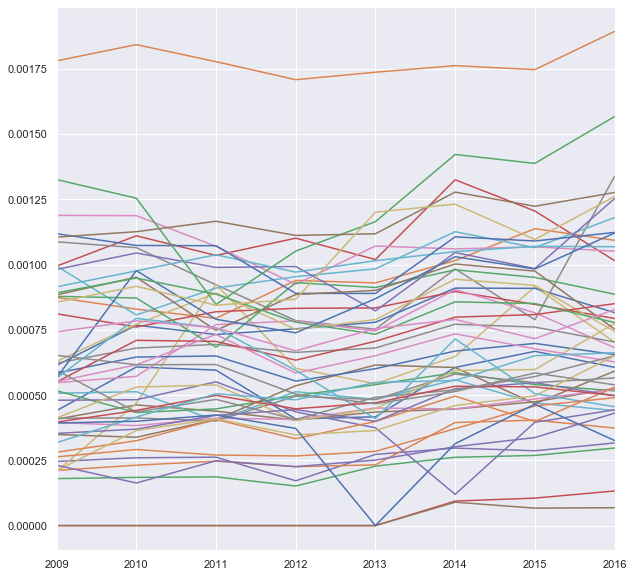

In [110]:
fig,ax = plt.subplots()
years = range(2009,2017)
fires_by_state[years].transpose().plot(ax=ax, legend=False)
# a=ax.set_xticklabels(range(2012,2015))
fig.set_size_inches((10,10))

In [70]:
fires_by_state[tot_cols].head()

,"(2009, tot_fires)","(2010, tot_fires)","(2011, tot_fires)","(2012, tot_fires)","(2013, tot_fires)","(2014, tot_fires)","(2015, tot_fires)","(2016, tot_fires)"
STATE,,,,,,,,
01,2132.0,2941.0,2883.0,1977.0,2017.0,2933.0,3231.0,2935.0
02,644.0,611.0,585.0,692.0,685.0,748.0,838.0,805.0
04,1211.0,1242.0,1255.0,1019.0,1532.0,1760.0,1808.0,1999.0
05,2950.0,3295.0,3072.0,3268.0,3025.0,3932.0,3577.0,3013.0
06,9494.0,10042.0,10133.0,6633.0,10537.0,11479.0,11076.0,12235.0


In [68]:
fires_by_state[(2009,'tot_fires')].head()

STATE
01    2132.0
02     644.0
04    1211.0
05    2950.0
06    9494.0
Name: (2009, tot_fires), dtype: float64

In [62]:
fires_by_state.columns

Index([            'E_TOTPOP', (2009, 'not_sev_fire'),     (2009, 'sev_fire'),
          (2009, 'tot_fires'), (2010, 'not_sev_fire'),     (2010, 'sev_fire'),
          (2010, 'tot_fires'), (2011, 'not_sev_fire'),     (2011, 'sev_fire'),
          (2011, 'tot_fires'), (2012, 'not_sev_fire'),     (2012, 'sev_fire'),
          (2012, 'tot_fires'), (2013, 'not_sev_fire'),     (2013, 'sev_fire'),
          (2013, 'tot_fires'), (2014, 'not_sev_fire'),     (2014, 'sev_fire'),
          (2014, 'tot_fires'), (2015, 'not_sev_fire'),     (2015, 'sev_fire'),
          (2015, 'tot_fires'), (2016, 'not_sev_fire'),     (2016, 'sev_fire'),
          (2016, 'tot_fires')],
      dtype='object')

In [61]:
fires_by_state

,E_TOTPOP,"(2009, not_sev_fire)","(2009, sev_fire)","(2009, tot_fires)","(2010, not_sev_fire)","(2010, sev_fire)","(2010, tot_fires)","(2011, not_sev_fire)","(2011, sev_fire)","(2011, tot_fires)","(2012, not_sev_fire)","(2012, sev_fire)","(2012, tot_fires)","(2013, not_sev_fire)","(2013, sev_fire)","(2013, tot_fires)","(2014, not_sev_fire)","(2014, sev_fire)","(2014, tot_fires)","(2015, not_sev_fire)","(2015, sev_fire)","(2015, tot_fires)","(2016, not_sev_fire)","(2016, sev_fire)","(2016, tot_fires)"
STATE,,,,,,,,,,,,,,,,,,,,,,,,,
01,4841164.0,1729.0,403.0,2132.0,2286.0,655.0,2941.0,2317.0,566.0,2883.0,1537.0,440.0,1977.0,1564.0,453.0,2017.0,2345.0,588.0,2933.0,9.0,3222.0,3231.0,2294.0,641.0,2935.0
02,736855.0,457.0,187.0,644.0,446.0,165.0,611.0,409.0,176.0,585.0,505.0,187.0,692.0,505.0,180.0,685.0,510.0,238.0,748.0,0.0,838.0,838.0,594.0,211.0,805.0
04,6728577.0,778.0,433.0,1211.0,873.0,369.0,1242.0,813.0,442.0,1255.0,663.0,356.0,1019.0,1063.0,469.0,1532.0,1294.0,466.0,1760.0,9.0,1799.0,1808.0,1643.0,356.0,1999.0
05,2968472.0,1961.0,989.0,2950.0,2206.0,1089.0,3295.0,2064.0,1008.0,3072.0,2168.0,1100.0,3268.0,2033.0,992.0,3025.0,2639.0,1293.0,3932.0,3.0,3574.0,3577.0,2113.0,900.0,3013.0
06,38654206.0,7279.0,2215.0,9494.0,7838.0,2204.0,10042.0,7884.0,2249.0,10133.0,5050.0,1583.0,6633.0,7972.0,2565.0,10537.0,8527.0,2952.0,11479.0,96.0,10980.0,11076.0,9663.0,2572.0,12235.0
08,5359295.0,1793.0,391.0,2184.0,1977.0,500.0,2477.0,1890.0,459.0,2349.0,1768.0,399.0,2167.0,1886.0,446.0,2332.0,1967.0,425.0,2392.0,101.0,2441.0,2542.0,2328.0,489.0,2817.0
09,3588570.0,3898.0,366.0,4264.0,3880.0,380.0,4260.0,3482.0,357.0,3839.0,2981.0,335.0,3316.0,3460.0,383.0,3843.0,3344.0,459.0,3803.0,87.0,3744.0,3831.0,3372.0,400.0,3772.0
10,934695.0,973.0,43.0,1016.0,940.0,55.0,995.0,831.0,31.0,862.0,689.0,45.0,734.0,658.0,45.0,703.0,872.0,47.0,919.0,2.0,735.0,737.0,1203.0,47.0,1250.0
11,659009.0,73.0,64.0,137.0,272.0,37.0,309.0,522.0,87.0,609.0,338.0,59.0,397.0,314.0,44.0,358.0,404.0,23.0,427.0,0.0,603.0,603.0,401.0,62.0,463.0


In [59]:
df.head()

,STCNTY,E_TOTPOP,"(2009, not_sev_fire)","(2009, sev_fire)","(2009, tot_fires)","(2010, not_sev_fire)","(2010, sev_fire)","(2010, tot_fires)","(2011, not_sev_fire)","(2011, sev_fire)","(2011, tot_fires)","(2012, not_sev_fire)","(2012, sev_fire)","(2012, tot_fires)","(2013, not_sev_fire)","(2013, sev_fire)","(2013, tot_fires)","(2014, not_sev_fire)","(2014, sev_fire)","(2014, tot_fires)","(2015, not_sev_fire)","(2015, sev_fire)","(2015, tot_fires)","(2016, not_sev_fire)","(2016, sev_fire)","(2016, tot_fires)",STATE
0,01001,55049.0,26.0,13.0,39.0,18.0,9.0,27.0,22.0,7.0,29.0,12.0,2.0,14.0,20.0,4.0,24.0,9.0,2.0,11.0,1.0,30.0,31.0,19.0,8.0,27.0,01
1,01003,199510.0,57.0,16.0,73.0,79.0,15.0,94.0,56.0,20.0,76.0,75.0,13.0,88.0,69.0,10.0,79.0,110.0,25.0,135.0,0.0,100.0,100.0,82.0,15.0,97.0,01
2,01005,26614.0,7.0,3.0,10.0,12.0,0.0,12.0,4.0,0.0,4.0,3.0,5.0,8.0,1.0,0.0,1.0,3.0,6.0,9.0,0.0,3.0,3.0,4.0,1.0,5.0,01
3,01007,22572.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,2.0,3.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,1.0,2.0,3.0,01
4,01009,57704.0,17.0,4.0,21.0,19.0,4.0,23.0,13.0,14.0,27.0,11.0,5.0,16.0,8.0,4.0,12.0,13.0,4.0,17.0,0.0,16.0,16.0,43.0,5.0,48.0,01


In [55]:
nfirs_svi_counties.head()

,E_TOTPOP,"(2009, not_sev_fire)","(2009, sev_fire)","(2009, tot_fires)","(2010, not_sev_fire)","(2010, sev_fire)","(2010, tot_fires)","(2011, not_sev_fire)","(2011, sev_fire)","(2011, tot_fires)","(2012, not_sev_fire)","(2012, sev_fire)","(2012, tot_fires)","(2013, not_sev_fire)","(2013, sev_fire)","(2013, tot_fires)","(2014, not_sev_fire)","(2014, sev_fire)","(2014, tot_fires)","(2015, not_sev_fire)","(2015, sev_fire)","(2015, tot_fires)","(2016, not_sev_fire)","(2016, sev_fire)","(2016, tot_fires)"
STCNTY,,,,,,,,,,,,,,,,,,,,,,,,,
01001,55049.0,26.0,13.0,39.0,18.0,9.0,27.0,22.0,7.0,29.0,12.0,2.0,14.0,20.0,4.0,24.0,9.0,2.0,11.0,1.0,30.0,31.0,19.0,8.0,27.0
01003,199510.0,57.0,16.0,73.0,79.0,15.0,94.0,56.0,20.0,76.0,75.0,13.0,88.0,69.0,10.0,79.0,110.0,25.0,135.0,0.0,100.0,100.0,82.0,15.0,97.0
01005,26614.0,7.0,3.0,10.0,12.0,0.0,12.0,4.0,0.0,4.0,3.0,5.0,8.0,1.0,0.0,1.0,3.0,6.0,9.0,0.0,3.0,3.0,4.0,1.0,5.0
01007,22572.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,2.0,3.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,1.0,2.0,3.0
01009,57704.0,17.0,4.0,21.0,19.0,4.0,23.0,13.0,14.0,27.0,11.0,5.0,16.0,8.0,4.0,12.0,13.0,4.0,17.0,0.0,16.0,16.0,43.0,5.0,48.0


In [39]:
a.head()

,ST_ABBR,COUNTY,E_TOTPOP,avg_tot_fire_rate_per_cap,std_tot_fire_rate_per_cap,avg_sev_fire_rate_per_cap,std_sev_fire_rate_per_cap,2009_tot_fire_rate_per_cap,2009_sev_fire_rate_per_cap,2010_tot_fire_rate_per_cap,2010_sev_fire_rate_per_cap,2011_tot_fire_rate_per_cap,2011_sev_fire_rate_per_cap,2012_tot_fire_rate_per_cap,2012_sev_fire_rate_per_cap,2013_tot_fire_rate_per_cap,2013_sev_fire_rate_per_cap,2014_tot_fire_rate_per_cap,2014_sev_fire_rate_per_cap,2015_tot_fire_rate_per_cap,2015_sev_fire_rate_per_cap,2016_tot_fire_rate_per_cap,2016_sev_fire_rate_per_cap
STCNTY,,,,,,,,,,,,,,,,,,,,,,,
25025,MA,Suffolk,767719.0,0.004143,0.000239,0.000666,0.001226,0.004113,0.000223,0.004129,0.000225,0.004004,0.000225,0.003859,0.000215,0.004094,0.000276,0.004298,0.000225,0.004001,0.003699,0.004645,0.000242
36005,NY,Bronx,1436785.0,0.002924,0.000339,0.000088,0.000155,0.003026,0.000026,0.003064,0.000032,0.002359,0.000023,0.002431,0.000031,0.002946,0.000040,0.003227,0.000031,0.003167,0.000470,0.003171,0.000047
05069,AR,Jefferson,72385.0,0.002787,0.000745,0.001228,0.000872,0.002349,0.000815,0.003260,0.001299,0.002956,0.000995,0.003081,0.001188,0.002929,0.000939,0.003398,0.001243,0.003205,0.003191,0.001119,0.000152
28119,MS,Quitman,7634.0,0.002685,0.000697,0.001261,0.000831,0.002620,0.000655,0.002358,0.001048,0.001703,0.000655,0.003668,0.001310,0.002227,0.001048,0.002227,0.000655,0.003144,0.003144,0.003537,0.001572
05095,AR,Monroe,7542.0,0.002536,0.000794,0.001442,0.000813,0.003050,0.001061,0.001326,0.000663,0.002519,0.001193,0.002652,0.001724,0.002519,0.001724,0.003580,0.001326,0.003182,0.003182,0.001458,0.000663


In [50]:
averages = nfirs_svi_counties_rates[tot_cols].mean()

[Text(0, 0, '2009'),
 Text(0, 0, '2010'),
 Text(0, 0, '2011'),
 Text(0, 0, '2012'),
 Text(0, 0, '2013'),
 Text(0, 0, '2014'),
 Text(0, 0, '2015'),
 Text(0, 0, '2016')]

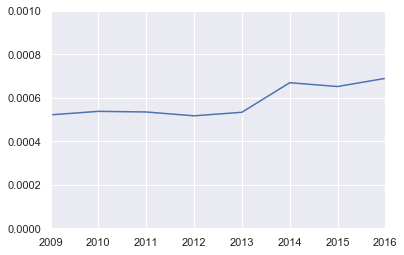

In [54]:
fig,ax = plt.subplots()
averages.plot()
ax.set_ylim(0,.001)
ax.set_xticklabels(range(2009,2017))

In [51]:
averages

2009_tot_fire_rate_per_cap    0.000522
2010_tot_fire_rate_per_cap    0.000538
2011_tot_fire_rate_per_cap    0.000535
2012_tot_fire_rate_per_cap    0.000517
2013_tot_fire_rate_per_cap    0.000534
2014_tot_fire_rate_per_cap    0.000670
2015_tot_fire_rate_per_cap    0.000652
2016_tot_fire_rate_per_cap    0.000690
dtype: float64

In [36]:
nfirs_svi_counties_rates.head()

,ST_ABBR,COUNTY,E_TOTPOP,avg_tot_fire_rate_per_cap,std_tot_fire_rate_per_cap,avg_sev_fire_rate_per_cap,std_sev_fire_rate_per_cap,2009_tot_fire_rate_per_cap,2009_sev_fire_rate_per_cap,2010_tot_fire_rate_per_cap,2010_sev_fire_rate_per_cap,2011_tot_fire_rate_per_cap,2011_sev_fire_rate_per_cap,2012_tot_fire_rate_per_cap,2012_sev_fire_rate_per_cap,2013_tot_fire_rate_per_cap,2013_sev_fire_rate_per_cap,2014_tot_fire_rate_per_cap,2014_sev_fire_rate_per_cap,2015_tot_fire_rate_per_cap,2015_sev_fire_rate_per_cap,2016_tot_fire_rate_per_cap,2016_sev_fire_rate_per_cap
STCNTY,,,,,,,,,,,,,,,,,,,,,,,
01001,AL,Autauga,55049.0,0.000459,0.000164,0.000170,0.000166,0.000708,0.000236,0.000490,0.000163,0.000527,0.000127,0.000254,0.000036,0.000436,0.000073,0.000200,0.000036,0.000563,0.000545,0.000490,0.000145
01003,AL,Baldwin,199510.0,0.000465,0.000099,0.000134,0.000150,0.000366,0.000080,0.000471,0.000075,0.000381,0.000100,0.000441,0.000065,0.000396,0.000050,0.000677,0.000125,0.000501,0.000501,0.000486,0.000075
01005,AL,Barbour,26614.0,0.000244,0.000143,0.000085,0.000089,0.000376,0.000113,0.000451,0.000000,0.000150,0.000000,0.000301,0.000188,0.000038,0.000000,0.000338,0.000225,0.000113,0.000113,0.000188,0.000038
01007,AL,Bibb,22572.0,0.000072,0.000062,0.000044,0.000033,0.000044,0.000044,0.000044,0.000044,0.000089,0.000044,0.000177,0.000044,0.000000,0.000000,0.000000,0.000000,0.000089,0.000089,0.000133,0.000089
01009,AL,Blount,57704.0,0.000390,0.000196,0.000121,0.000086,0.000364,0.000069,0.000399,0.000069,0.000468,0.000243,0.000277,0.000087,0.000208,0.000069,0.000295,0.000069,0.000277,0.000277,0.000832,0.000087


# 4. Task 5
- Task 5: <b>Home Fire Predictablility Assessment</b>: Using Census Tract Fire Severity Assesment bin Data at 3-month 6-month or 1-year intervals and train simple linear/logistic regression model

1 year intervals will be used to capture the temporal aspect of the data, which occurs at one year intervals (most fires occur during the winter months)

## 4.1 Plotting correlation coefficients

In [22]:
def plot_correlation_matrix_heat_map(df,label,qty_fields=10):
    df = pd.concat([df[label],df.drop(label,axis=1)],axis=1)
    correlation_matrix = df.corr()
    index = correlation_matrix.sort_values(label, ascending=False).index
    correlation_matrix = correlation_matrix[index].sort_values(label,ascending=False)

    fig,ax = plt.subplots()
    fig.set_size_inches((10,10))
    sns.heatmap(correlation_matrix.iloc[:qty_fields,:qty_fields],annot=True,fmt='.2f',ax=ax)
    return(fig,ax)

### 4.1.1 County correlation heat maps

(<Figure size 720x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1819b1d3b38>)

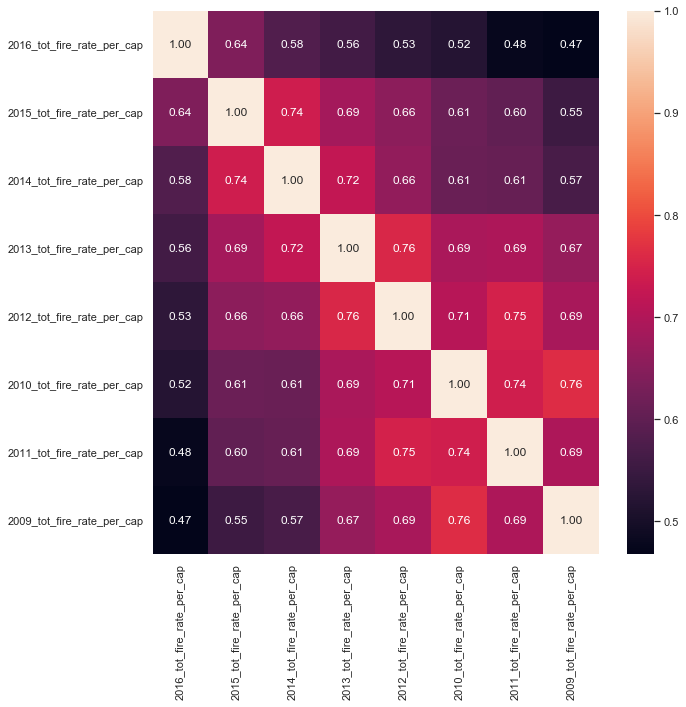

In [23]:
plot_correlation_matrix_heat_map(nfirs_svi_counties_rates[tot_cols],'2016_tot_fire_rate_per_cap')

(<Figure size 720x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x181b4aaf668>)

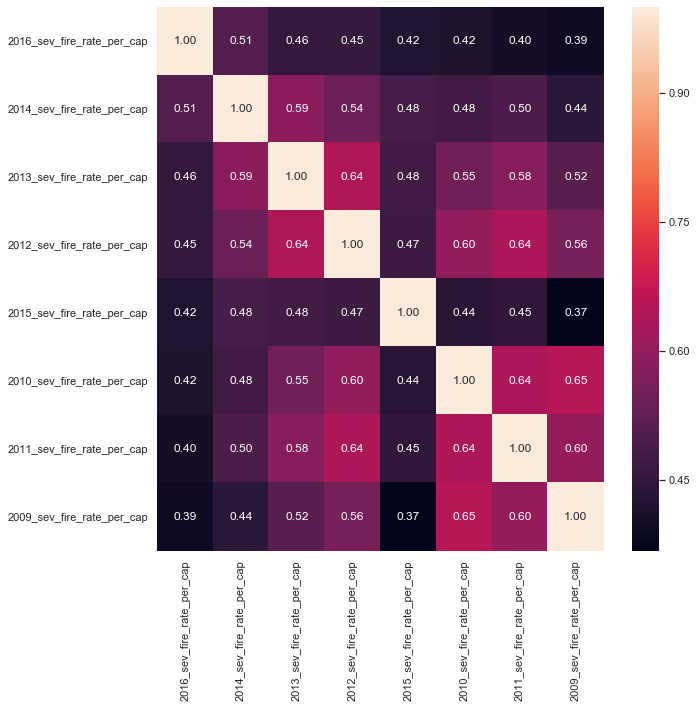

In [24]:
plot_correlation_matrix_heat_map(nfirs_svi_counties_rates[sev_cols],'2016_sev_fire_rate_per_cap')

### 4.1.2 Census tract correlation heat maps

(<Figure size 720x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x181bd9ccfd0>)

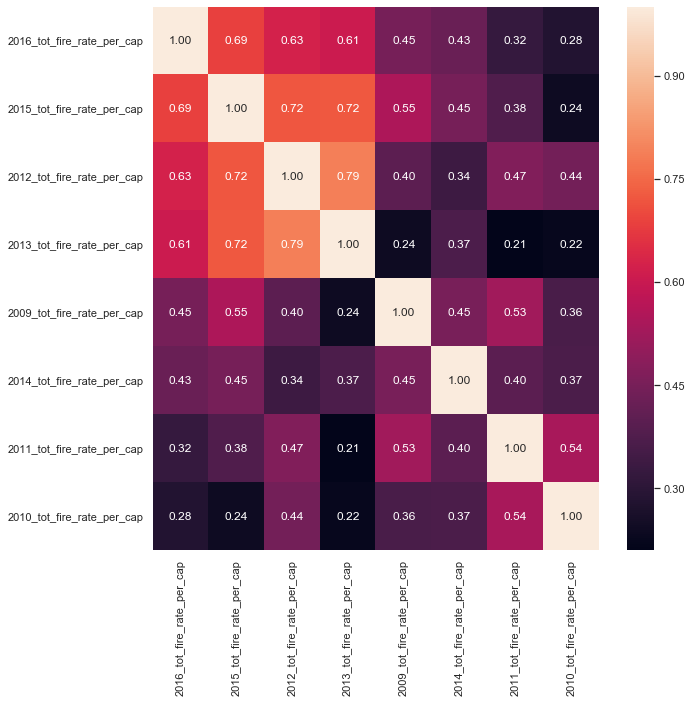

In [25]:
plot_correlation_matrix_heat_map(nfirs_svi_tracts_rates[tot_cols],'2016_tot_fire_rate_per_cap')

## Linear Regression Model

In [26]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression

I'll use the yearly aggregated rates to create a simple linear regression algorithm to predict the rate for 2016 by census tract

In [27]:
def null_counts(df):
    null_df = pd.DataFrame(df.isnull().sum(),columns=['null_count'])
    null_df['null_fraction'] = null_df['null_count'] / df.shape[0]
    null_df = null_df.sort_values('null_count',ascending=False)
    return null_df

In [28]:
null_counts(nfirs_svi_tracts_rates)

,null_count,null_fraction
2013_sev_fire_rate_per_cap,4750,0.065215
2012_sev_fire_rate_per_cap,4750,0.065215
std_tot_fire_rate_per_cap,4750,0.065215
std_sev_fire_rate_per_cap,4750,0.065215
2009_sev_fire_rate_per_cap,4750,0.065215
2014_sev_fire_rate_per_cap,4749,0.065201
2010_sev_fire_rate_per_cap,4749,0.065201
2011_sev_fire_rate_per_cap,4748,0.065188
2016_sev_fire_rate_per_cap,4747,0.065174
2009_tot_fire_rate_per_cap,4747,0.065174


In [29]:
tot_cols

Index(['2009_tot_fire_rate_per_cap', '2010_tot_fire_rate_per_cap',
       '2011_tot_fire_rate_per_cap', '2012_tot_fire_rate_per_cap',
       '2013_tot_fire_rate_per_cap', '2014_tot_fire_rate_per_cap',
       '2015_tot_fire_rate_per_cap', '2016_tot_fire_rate_per_cap'],
      dtype='object')

In [30]:
label = '2016_tot_fire_rate_per_cap'
# features = tot_cols.drop(label)
features = ['2014_tot_fire_rate_per_cap','2015_tot_fire_rate_per_cap']

X_train, X_test, y_train, y_test = train_test_split(nfirs_svi_tracts_rates.dropna()[features],nfirs_svi_tracts_rates.dropna()[label],train_size=.8,random_state=1)

In [31]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train,y_train,random_state=1)

In [32]:
lr = LinearRegression()
lr.fit(X_train2,y_train2)
lr.score(X_train2,y_train2)

0.6103114199095088

In [33]:
lr = LinearRegression()
cross_val_score(lr,X_train,y_train,cv=10)

array([ 0.43255515,  0.34956002,  0.38157443,  0.77108122,  0.42177448,
        0.68032207,  0.35967215, -0.15691824,  0.45037743,  0.37971549])

In [34]:
nfirs_svi_tracts_rates.sample(5,random_state=1)

,ST_ABBR,COUNTY,E_TOTPOP,LOCATION,avg_tot_fire_rate_per_cap,std_tot_fire_rate_per_cap,avg_sev_fire_rate_per_cap,std_sev_fire_rate_per_cap,2009_tot_fire_rate_per_cap,2009_sev_fire_rate_per_cap,2010_tot_fire_rate_per_cap,2010_sev_fire_rate_per_cap,2011_tot_fire_rate_per_cap,2011_sev_fire_rate_per_cap,2012_tot_fire_rate_per_cap,2012_sev_fire_rate_per_cap,2013_tot_fire_rate_per_cap,2013_sev_fire_rate_per_cap,2014_tot_fire_rate_per_cap,2014_sev_fire_rate_per_cap,2015_tot_fire_rate_per_cap,2015_sev_fire_rate_per_cap,2016_tot_fire_rate_per_cap,2016_sev_fire_rate_per_cap
GEOID,,,,,,,,,,,,,,,,,,,,,,,,
36063022100,NY,Niagara,2360.0,"Census Tract 221, Niagara County, New York",0.000583,0.000503,0.000212,0.000320,0.000847,0.000424,0.000000,0.000000,0.000000,0.000000,0.001271,0.000000,0.000847,0.000424,0.000000,0.000000,0.000847,0.000847,0.000847,0.000000
36005002800,NY,Bronx,5350.0,"Census Tract 28, Bronx County, New York",0.002126,0.000519,0.000047,0.000132,0.002430,0.000000,0.001495,0.000000,0.001308,0.000000,0.002243,0.000000,0.002430,0.000000,0.002430,0.000000,0.002804,0.000374,0.001869,0.000000
27109002100,MN,Olmsted,6400.0,"Census Tract 21, Olmsted County, Minnesota",0.000078,0.000221,0.000020,0.000055,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000625,0.000156,0.000000,0.000000,0.000000,0.000000
36047089800,NY,Kings,1676.0,"Census Tract 898, Kings County, New York",0.007757,0.008775,0.000597,0.001462,0.002387,0.000000,0.001193,0.000000,0.001193,0.000000,0.001193,0.000000,0.001193,0.000000,0.016706,0.000000,0.019690,0.004177,0.018496,0.000597
39093010300,OH,Lorain,5416.0,"Census Tract 103, Lorain County, Ohio",0.000923,0.000503,0.000300,0.000355,0.000554,0.000000,0.002031,0.000185,0.000739,0.000369,0.001108,0.000369,0.000554,0.000185,0.000739,0.000185,0.001108,0.001108,0.000554,0.000000
